# 데이터 전처리 최종 정리(회귀분석 7조)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("Health_systems.csv")
train = pd.read_csv('train.csv') # 확진자수 데이터
pop = pd.read_csv('population.csv') # 인구, 인구밀도 데이터

## 1) 원래 데이터 탐색
- Country_Region : kaggle Covid-19 에서 사용되는 지역 이름  
- Province_State : 중국의 홍콩, 마카오 요런 느낌(도, 주)  
- WorldBankName : World Bank 에서 사용하는 국가의 이름  
- Health_exp_pct_GDP_2016 : GDP의 백분율로 표현되는 현재 건강 지출 수준    
 > 매년 소비되는 의료 상품과 서비스 포함
- Health_exp_public_pct_2016 : 국내 공공 의료원으로부터 자금을 지원받은 현재 의료비 분담  
- **Health_exp_out_of_pocket_pct_2016 : 현재 총 의료비 지출의 현금 외 지불 분담.**   
- **Health_exp_per_capita_USD_2016 : 현재 미국 달러로 1인당 보건에 대한 지출(의료재화, 서비스 포함)**    
- **per_capita_exp_PPP_2016 : PPP(구매력 평가)에서 국제 달러로 표시되는 1인당 보건에 대한 현재 지출**  
- External_health_exp_pct_2016 : 외부 출처에서 자금을 조달한 현재 의료 지출의 몫     
- Completeness_of_birth_reg_2009-18 : 출생신고 완료율    
- Completeness_of_death_reg_2008-16 : 완전 사망 기준(사망자 추정 비율) 

In [2]:
# 원래 데이터
data.head(3)

,Country_Region,Province_State,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,NaN,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
1,Albania,NaN,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53.0
2,Algeria,NaN,Algeria,6.6,67.7,30.9,260.4,998.2,0.0,1.8,2.2,12.1,100.0,NaN


In [3]:
data.isna().sum() 
# 결측치도 너무 많고 2016년 자료라 설명력이 떨어집니다. 

Country_Region                           23
Province_State                          196
World_Bank_Name                           0
Health_exp_pct_GDP_2016                  24
Health_exp_public_pct_2016               24
Health_exp_out_of_pocket_pct_2016        24
Health_exp_per_capita_USD_2016           24
per_capita_exp_PPP_2016                  24
External_health_exp_pct_2016             43
Physicians_per_1000_2009-18              21
Nurse_midwife_per_1000_2009-18           21
Specialist_surgical_per_1000_2008-18     35
Completeness_of_birth_reg_2009-18        47
Completeness_of_death_reg_2008-16       103
dtype: int64

## 2) 외부데이터 탐색과 전처리

원래 데이터만으로 설명력이 부족하다고 생각해 캐글 커널에서 제공하는 다른 외부 데이터를 가져왔습니다.     
https://www.kaggle.com/danevans/world-bank-wdi-212-health-systems/kernels   
1. pop 데이터 : 각 나라별 인구 수와 성별 비율 등의 정보가 담긴 데이터입니다. 

In [4]:
pop.head(3)

,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,restrictions,...,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
0,Afghanistan,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,...,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
1,Albania,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,...,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04
2,Algeria,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,...,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81


In [5]:
pop['pop'] = pop['pop'].str.replace(",", "").astype('float64')
# '인구' 열의 , 를 공백으로 대체하여 ,를 삭제합니다. 

2. train 데이터 : 날짜에 따라 나라별로 확진자수와 사망자수가 나와있는 데이터입니다. 

In [6]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [7]:
# 전처리합니다. 
# datetime 함수를 이용해 자료형을 date로 바꿉니다. 
train['Date'] = pd.to_datetime(train.Date)
train['country_province'] = train['Province_State']
train.country_province.fillna(train['Country_Region'], inplace=True)

# pop, train, 그리고 원래 data를 나라 이름을 기준으로 합칩니다. 
train = train.merge(pop, how='left', left_on = ['country_province'], right_on=['country'])
train = train.merge(data, how='left', left_on=["Country_Region", "Province_State"], right_on = ["Country_Region", "Province_State"])

In [8]:
train.head(2) # 새로운 데이터셋이 만들어졌습니다. 

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_province,country,pop,tests,...,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN


In [9]:
train.columns
# 칼럼은 다음과 같습니다. 여기서 유의한 피쳐 몇개만 사용할 예정입니다. 

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'country_province', 'country', 'pop', 'tests', 'testpop',
       'density', 'medianage', 'urbanpop', 'quarantine', 'schools',
       'restrictions', 'hospibed', 'smokers', 'sex0', 'sex14', 'sex25',
       'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung',
       'malelung', 'World_Bank_Name', 'Health_exp_pct_GDP_2016',
       'Health_exp_public_pct_2016', 'Health_exp_out_of_pocket_pct_2016',
       'Health_exp_per_capita_USD_2016', 'per_capita_exp_PPP_2016',
       'External_health_exp_pct_2016', 'Physicians_per_1000_2009-18',
       'Nurse_midwife_per_1000_2009-18',
       'Specialist_surgical_per_1000_2008-18',
       'Completeness_of_birth_reg_2009-18',
       'Completeness_of_death_reg_2008-16'],
      dtype='object')

### 주어진 데이터를 바탕으로 새로운 변수를 만듭니다. 
- days_from_first_case : 첫 확진자가 나온 후부터 누적 날짜 수
- days_from_first_death : 첫 사망자가 나온 후부터 누적 날짜 수
- days_from_case_100 : 100명의 확진자가 나온 후부터 누적 날짜 수

In [10]:
test= pd.read_csv('health_test.csv')
test['Date'] = pd.to_datetime(test.Date)
test['country_province'] = test['Province_State']
test.country_province.fillna(test['Country_Region'], inplace=True) # 결측치 채움

test = test.merge(pop, how='left', left_on = ['country_province'], right_on=['country'])
test = test.merge(data, how='left', left_on=["Country_Region", "Province_State"], right_on = ["Country_Region", "Province_State"])
test["days"] = (test.Date - test.Date[0]).dt.days
test.head(3)

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
test['country_province'] = lb.fit_transform(test.country_province)

train["days_from_first_case"] = 0
test["days_from_first_case"] = 0
train["days_from_first_death"] = 0
train["days_from_case_100"] = 0
test["days_from_case_100"] = 0
test["days_from_first_death"] = 0

dates = list(train.Date.unique())
for province in train.country_province.unique():
    #print(province)
    mask1 = train.country_province == province
    mask2 = train.ConfirmedCases > 1.0
    mask3 = train.ConfirmedCases > 100.0
    mask4 = train.Fatalities > 1.0
    try:
        idx1 = train.loc[mask1 & mask2 ,["ConfirmedCases"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    #print(dateidx1)
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_first_case"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_first_case"] = (test.Date - dateidx1).dt.days
    
    try:
        idx1 = train.loc[mask1 & mask3 ,["ConfirmedCases"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_case_100"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_case_100"] = (test.Date - dateidx1).dt.days    

        
    try:
        idx1 = train.loc[mask1 & mask4 ,["Fatalities"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_first_death"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_first_death"] = (test.Date - dateidx1).dt.days    

In [11]:
# 새로운 칼럼이 추가된 데이터셋입니다. 
train.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'country_province', 'country', 'pop', 'tests', 'testpop',
       'density', 'medianage', 'urbanpop', 'quarantine', 'schools',
       'restrictions', 'hospibed', 'smokers', 'sex0', 'sex14', 'sex25',
       'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung',
       'malelung', 'World_Bank_Name', 'Health_exp_pct_GDP_2016',
       'Health_exp_public_pct_2016', 'Health_exp_out_of_pocket_pct_2016',
       'Health_exp_per_capita_USD_2016', 'per_capita_exp_PPP_2016',
       'External_health_exp_pct_2016', 'Physicians_per_1000_2009-18',
       'Nurse_midwife_per_1000_2009-18',
       'Specialist_surgical_per_1000_2008-18',
       'Completeness_of_birth_reg_2009-18',
       'Completeness_of_death_reg_2008-16', 'days_from_first_case',
       'days_from_first_death', 'days_from_case_100'],
      dtype='object')

In [12]:
train.head(2)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_province,country,pop,tests,...,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,days_from_first_case,days_from_first_death,days_from_case_100
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,162.8,17.5,0.3,0.3,0.0,42.3,NaN,0,0,0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,162.8,17.5,0.3,0.3,0.0,42.3,NaN,0,0,0


In [13]:
# 시계열 영향 배제하기 위해 가장 최근 날짜만 가져옵니다. 
train = train.loc[train['Date'] == '2020-05-15']
train.reset_index(inplace=True)

In [14]:
train['Country_Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [15]:
# drop(겹치거나 필요 없는 행을 삭제합니다)
train.drop(columns=['index', 'Id', 'Province_State', 'Date', 'country_province', 'country', 'World_Bank_Name', 'quarantine', 'schools', 'tests', 'testpop', 'restrictions', 'smokers', 'Completeness_of_death_reg_2008-16'], inplace=True)

In [16]:
# 결측치를 제거합니다. 
train.fillna(value = 0, inplace = True)
train = train.loc[train['pop']!=0] 

In [17]:
train.shape 
# 결측치를 제거하니 153개만 남았습니다. 

(153, 31)

## 3) 히트맵을 통한 상관관계 파악

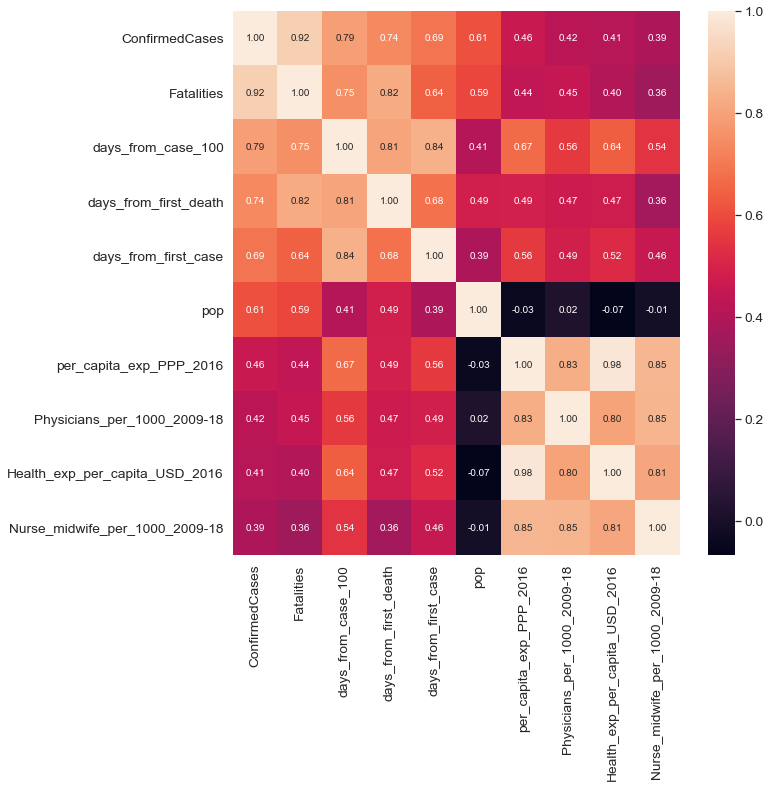

In [18]:
import scipy as sp 
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='ConfirmedCases').index
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, annot_kws={'size':10}, 
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

히트맵을 그려보니 다중공선성이 너무 높습니다. 따라서 다중공선성이 높거나, 사망자수 같은 너무 직접적인 변수는 제거합니다. 

In [21]:
train.drop(columns=['Fatalities', 'sex0', 'sex14', 'sex25', 'sex54',
       'sex64', 'sex65plus', 'sexratio', 'days_from_first_case'], inplace=True)

In [22]:
train.shape 
# 칼럼이 22개로 줄었습니다. 여기서 또 회귀 적합을 통해 유의미한 피쳐만 뽑을 예정입니다. 

(153, 22)

## 4) 변수 스케일링 
QQ플롯을 살펴보고, 회귀 모델에 적합하게 스케일링합니다.

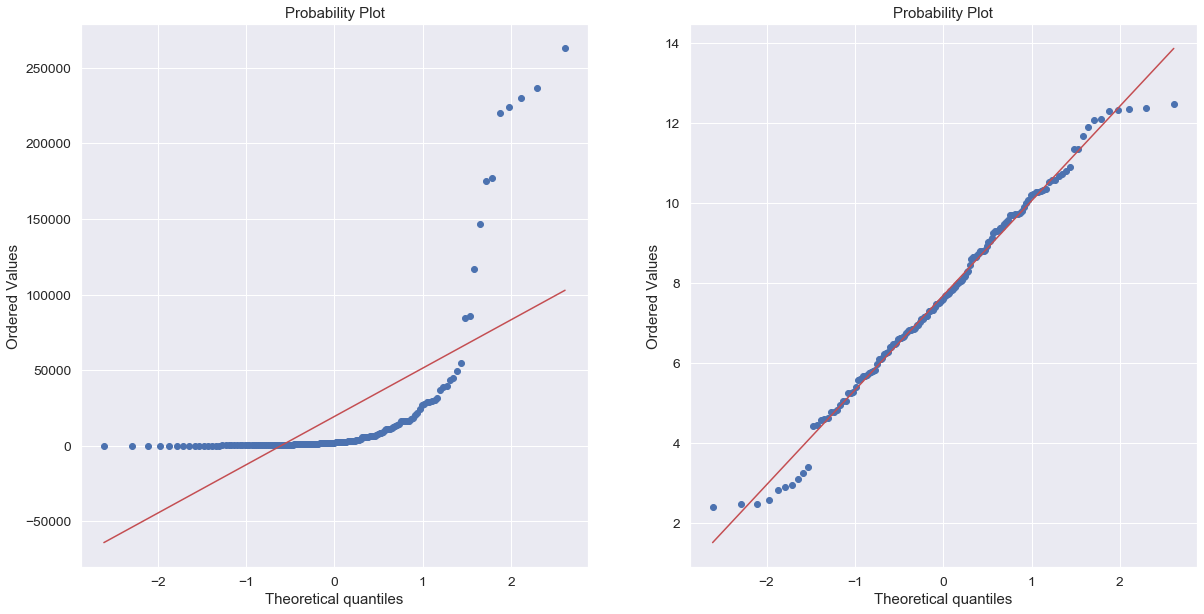

In [23]:
from scipy.stats import norm # 정규분포
from sklearn.preprocessing import StandardScaler
from scipy import stats 

# ConfirmedCases 정규화
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1) # (1,2,1) : 1*2 행렬의 첫번째 
res = stats.probplot( train['ConfirmedCases'], plot = plt)
fig.add_subplot(1,2,2)
res = stats.probplot( np.log1p(train['ConfirmedCases']), plot=plt)

로그를 씌우니 훨씬 QQ플롯에 잘 맞습니다.

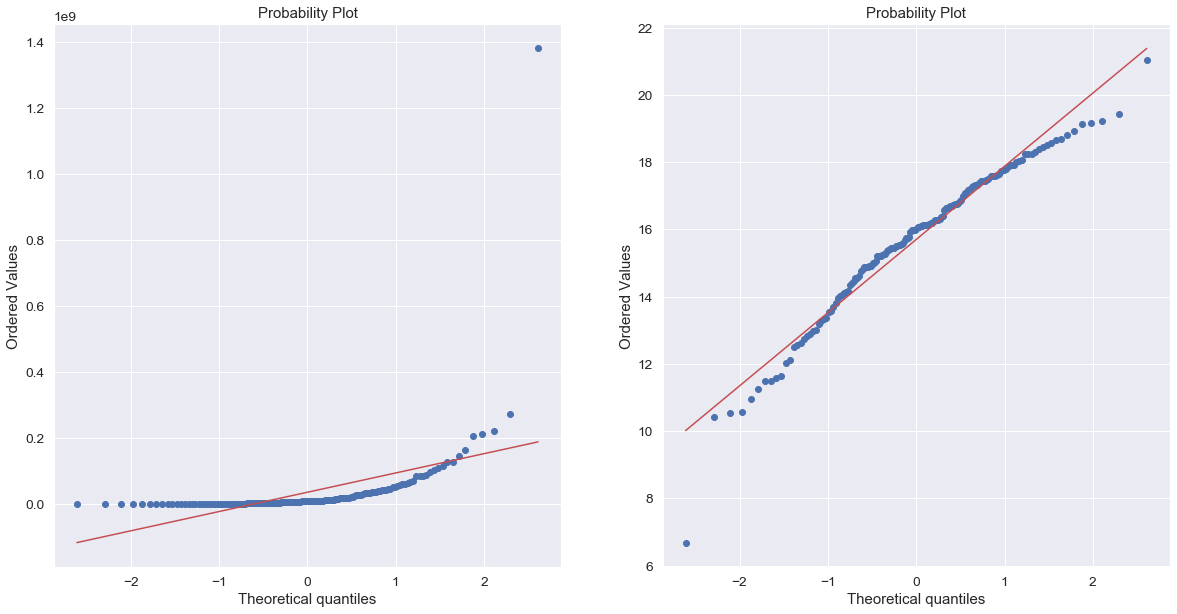

In [24]:
# population 열도 정규화합니다.  
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1) # (1,2,1) : 1*2 행렬의 첫번째 
res = stats.probplot(train['pop'], plot = plt)
fig.add_subplot(1,2,2)
res = stats.probplot( np.log1p(train['pop']), plot=plt)

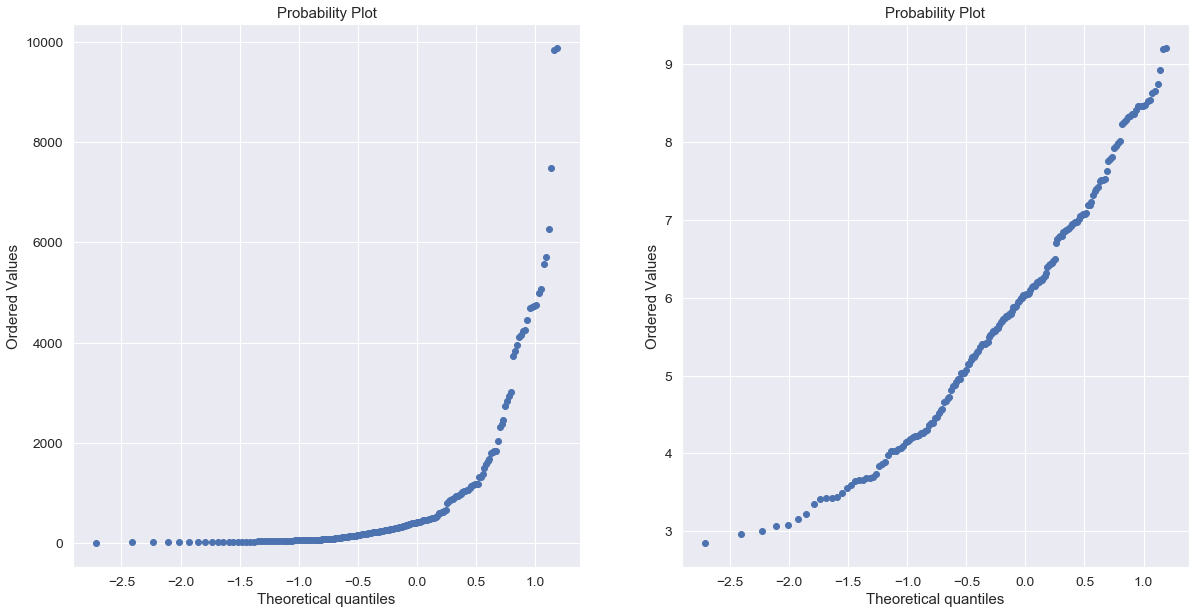

In [25]:
# Health_exp_per_capita_USD_2016열도 정규화합니다. 
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1) # (1,2,1) : 1*2 행렬의 첫번째 
res = stats.probplot( data['Health_exp_per_capita_USD_2016'], plot = plt)
fig.add_subplot(1,2,2)
res = stats.probplot( np.log1p(data['Health_exp_per_capita_USD_2016']), plot=plt)

ConfirmedCases, Pop, Health_exp_per_capita_USD_2016 열은 로그를 씌우는게 적합해보입니다. 

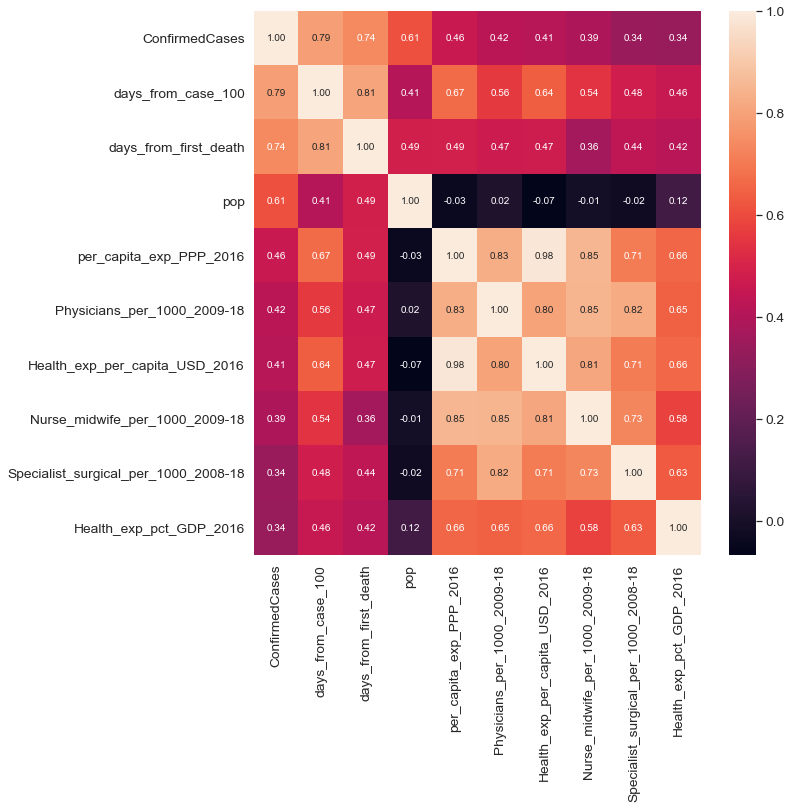

In [26]:
import scipy as sp 
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='ConfirmedCases').index
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, annot_kws={'size':10}, 
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)